I have a dictionary holding all my experiment results called results_dict, an example looks like this: 
results_dict['ResNet_ACC']['mean']['Ridge']['Test']['metrics'] = {'Naive MAE': 0.12141836789546905,
 'Naive MSE': 0.02367611469498394,
 'Model MAE': 0.09444778888604165,
 'Model MSE': 0.01891334753048512,
 'Improvement MAE': -0.22212931599152105,
 'Improvement MSE': -0.20116337607993873}

I want to convert it into a pandas data frame with perhaps multi index and multi column - not sure, depends. I will first describe the dictionary and then the desired data frame. Please then write me a function that I can adapt easily afterwards. 
Structre: 
- first level keys: are the names of the different experiments 
- second level keys: are the names of the different metrics
- third level keys: are the names of the different models used for prediction 
- fourth level keys: are the names of the different data sets used evaluated on, namely validation and test
- fifth level keys: are the names of the different evaluation metrics, such as Naive baseline, MAE, etc.

In [1]:
import os

import pyrootutils

PROJECT_ROOT_DIR = pyrootutils.setup_root(os.path.abspath(''), dotenv=True, pythonpath=True)
os.chdir(PROJECT_ROOT_DIR)


import random

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from sklearn.ensemble import (AdaBoostRegressor, GradientBoostingRegressor,
                              RandomForestRegressor)
from sklearn.linear_model import ElasticNet, Lasso, LinearRegression, Ridge
from sklearn.metrics import mean_absolute_error, mean_squared_error
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsRegressor
from sklearn.svm import SVR
from sklearn.tree import DecisionTreeRegressor

from src.utils_data_centric import _get_all_data_set_characteristics
from src.utils_performance import _all_algorithms_all_datasets_performance
from src.utils_visualization import NotebookFigureSaver

random_seed = 42
np.random.seed(random_seed)
random.seed(random_seed)

# Where to save the figures
CHAPTER_ID = "e_performance_estimation"
fig_saver = NotebookFigureSaver(CHAPTER_ID)

In [2]:
def evaluate_model(model, X_train, X_val, X_test, y_train, y_val, y_test):

    # Fit the model on the training data
    model.fit(X_train, y_train)

    # Predict on the validation set
    y_pred_val = model.predict(X_val)
    mae_val = mean_absolute_error(y_val, y_pred_val)
    mse_val = mean_squared_error(y_val, y_pred_val)

    # Predict on the test set
    y_pred_test = model.predict(X_test)
    mae_test = mean_absolute_error(y_test, y_pred_test)
    mse_test = mean_squared_error(y_test, y_pred_test)

    # Naive baseline performance for validation and test
    naive_baseline_val = np.repeat(y_train.mean(), len(y_val))
    naive_baseline_test = np.repeat(y_train.mean(), len(y_test))

    mae_naive_val = mean_absolute_error(naive_baseline_val, y_val)
    mse_naive_val = mean_squared_error(naive_baseline_val, y_val)
    mae_naive_test = mean_absolute_error(naive_baseline_test, y_test)
    mse_naive_test = mean_squared_error(naive_baseline_test, y_test)

    # Calculate relative improvement for validation and test for both MAE and MSE
    relative_improvement_mae_val = (mae_val - mae_naive_val) / mae_naive_val
    relative_improvement_mse_val = (mse_val - mse_naive_val) / mse_naive_val
    relative_improvement_mae_test = (mae_test - mae_naive_test) / mae_naive_test
    relative_improvement_mse_test = (mse_test - mse_naive_test) / mse_naive_test

    # Extending results_dict with MSE improvements
    results_dict = {
        "Validation": {
            "raw_predictions": {
                "GT Performance": y_val,
                "Estimated Performance": y_pred_val,
                "Naive Baseline": naive_baseline_val,
            },
            "metrics":{
                "Naive MAE": mae_naive_val,
                "Naive MSE": mse_naive_val,
                "Model MAE": mae_val,
                "Model MSE": mse_val,
                "Improvement MAE": relative_improvement_mae_val,
                "Improvement MSE": relative_improvement_mse_val,
            },
        },
        "Test": {
            "raw_predictions": {
                "GT Performance": y_test,
                "Estimated Performance": y_pred_test,
                "Naive Baseline": naive_baseline_test,
            },
            "metrics":{
                "Naive MAE": mae_naive_test,
                "Naive MSE": mse_naive_test,
                "Model MAE": mae_test,
                "Model MSE": mse_test,
                "Improvement MAE": relative_improvement_mae_test,
                "Improvement MSE": relative_improvement_mse_test,
            }
        }
    }
    
    return results_dict


def _get_best_model_for_each_task(results_dict, metric_to_use_for_selection):
    best_model_dict = {}
    for ts_algorithm_to_predict in results_dict.keys():
        best_model_dict[ts_algorithm_to_predict] = {}
        
        for performance_to_predict in results_dict[ts_algorithm_to_predict].keys():
            best_model = None
            best_model_improvement = np.inf
            for performance_estimator_model in results_dict[ts_algorithm_to_predict][performance_to_predict].keys():
                improvement = results_dict[ts_algorithm_to_predict][performance_to_predict][performance_estimator_model]["Validation"]["metrics"][metric_to_use_for_selection]
                if improvement < best_model_improvement:
                    best_model_improvement = improvement
                    best_model = performance_estimator_model
            print(f"Best model for {ts_algorithm_to_predict} and {performance_to_predict} is {best_model} with improvement {best_model_improvement}")
            test_performance = results_dict[ts_algorithm_to_predict][performance_to_predict][best_model]["Test"]["metrics"][metric_to_use_for_selection]
            best_model_dict[ts_algorithm_to_predict][performance_to_predict] = (best_model, {"validation":best_model_improvement.round(2),
                                                                                             "test":test_performance.round(2)})
    return best_model_dict

def _get_visual_frame(results_dict, metric_to_use_for_selection):
    
    best_model_dict = _get_best_model_for_each_task(results_dict, metric_to_use_for_selection)
    
    # first we need to build a dataframe with the data we want to visualize
    data_to_visualize = {}
    text_to_annotate = {}
    overall_data_frame = pd.DataFrame()
    # iterate over the time series algorithm which performance we want to predict
    for ts_algorithm_to_predict in best_model_dict.keys():
        
        # iterate over the characteristics of the performance we want to predict, namely the mean and the std
        for performance_to_predict in best_model_dict[ts_algorithm_to_predict].keys():
            best_model, performance = best_model_dict[ts_algorithm_to_predict][performance_to_predict]
            if ts_algorithm_to_predict not in data_to_visualize:
                data_to_visualize[ts_algorithm_to_predict] = {}
                text_to_annotate[ts_algorithm_to_predict] = {}
            data_to_visualize[ts_algorithm_to_predict][performance_to_predict] = best_model
            text_to_annotate[ts_algorithm_to_predict][performance_to_predict] = str(performance["validation"]) + " / " +str(performance["test"])
            overall_data_frame = pd.concat([overall_data_frame, pd.DataFrame({"Algorithm":ts_algorithm_to_predict,"predict":performance_to_predict, "Validation":performance["validation"], "Test":performance["test"]},index=[0])],ignore_index=True)
            
    data_to_visualize_df = pd.DataFrame(data_to_visualize).T
    
    return data_to_visualize_df, text_to_annotate, overall_data_frame

In [3]:
# get the characteristic statistics on all data sets
normalized_data_set_characteristics = _get_all_data_set_characteristics(
    multivariate=False, number_data_sets=None, normalize_each_characteristic=True
)
X = pd.DataFrame(normalized_data_set_characteristics)

# get the mean performance of all algorithms on all data sets
algorithm_data_set_performance = _all_algorithms_all_datasets_performance(
    performance_of_interest="$\\hat{\\mu}$", multivariate=False
)
# get the std performance "$\hat{\sigma}$" of all algorithms on all data sets
algorithm_data_set_performance_std = _all_algorithms_all_datasets_performance(
    performance_of_interest="$\hat{\sigma}$", multivariate=False
)

Y_mean = pd.DataFrame(algorithm_data_set_performance).T
Y_std = pd.DataFrame(algorithm_data_set_performance_std).T

# inner join x and y on index
matched_data_sets_mean = X.join(Y_mean, how="inner")
matched_data_sets_std = X.join(Y_std, how="inner")

In [4]:
algorithm_data_set_performance

,Adiac,ArrowHead,Beef,BeetleFly,BirdChicken,Car,CBF,ChlorineConcentration,CinCECGTorso,Coffee,...,GesturePebbleZ1Eq,GesturePebbleZ2Eq,KeplerLightCurves,MelbournePedestrianNmv,PhoneHeartbeatSound,PickupGestureWiimoteZEq,PLAIDEq,ShakeGestureWiimoteZEq,SharePriceIncrease,Tools
ResNet_ACC,0.815431,0.858667,0.676667,0.853333,0.945000,0.908333,0.988222,0.841007,0.767874,0.996429,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1NN-DTW_ACC,0.603410,0.722095,0.504444,0.775000,0.840000,0.675000,0.993481,0.644054,0.668502,0.985714,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
EE_ACC,0.657374,0.860381,0.515556,0.756667,0.836667,0.785556,0.982593,0.652778,0.934034,0.983333,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
WEASEL-D_ACC,0.817818,0.885143,0.776667,0.946667,0.933333,0.907778,0.980667,0.768030,0.925821,0.997619,...,0.961047,0.969198,0.923893,0.920885,0.640842,0.820667,0.898510,0.927333,0.686163,0.882587
RSF_ACC,0.669906,0.777714,0.466667,0.875000,0.833333,0.758333,0.970185,0.605920,0.771643,0.941667,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
CNN_ACC,0.387383,0.759810,0.667778,0.791667,0.705000,0.740000,0.934185,0.594080,0.660169,0.994048,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Catch22_ACC,0.697187,0.760000,0.484444,0.851667,0.888333,0.738889,0.950778,0.598741,0.800217,0.984524,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
TSF_ACC,0.715686,0.784190,0.677778,0.823333,0.821667,0.746111,0.963519,0.732144,0.971570,0.989286,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
RDST_ACC,0.739898,0.878286,0.742222,0.926667,0.913333,0.937778,0.990963,0.760035,0.982126,0.995238,...,0.971318,0.974895,0.928404,0.959465,0.668681,0.822000,0.917753,0.937333,0.660248,0.862687
TSFresh_ACC,0.789770,0.613143,0.734444,0.500000,0.608333,0.786667,0.984370,0.587049,0.953671,0.969048,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [5]:
# Define the regression models to test
models = {
    "RandomForest": RandomForestRegressor(n_estimators=100, random_state=42),
    "Ridge": Ridge(),
    "DecisionTree": DecisionTreeRegressor(min_samples_leaf=5, random_state=42),
    "SVR": SVR(),
    "KNeighbors": KNeighborsRegressor(),
    "GradientBoosting": GradientBoostingRegressor(),
    "AdaBoost": AdaBoostRegressor(),
}


test_size = 0.2
validation_size = 0.2
train_size = 1 - test_size - validation_size
random_seed = 0

results_dict = {}

for ts_algorithm_to_predict in Y_mean.columns:
    results_dict[ts_algorithm_to_predict] = {}

    for performance_to_predict in ["mean", "std"]:
        matched_data_sets = matched_data_sets_mean if performance_to_predict == "mean" else matched_data_sets_std

        X_train_val, X_test, y_train_val, y_test = train_test_split(
            matched_data_sets[X.columns],
            matched_data_sets[ts_algorithm_to_predict],
            test_size=test_size,
            random_state=random_seed,
        )
        
        X_train, X_val, y_train, y_val = train_test_split(X_train_val, y_train_val, test_size=validation_size/(train_size+validation_size), random_state=random_seed)


        results_dict[ts_algorithm_to_predict][performance_to_predict] = {}
        for performance_estimator_model, model in models.items():
            results_dict[ts_algorithm_to_predict][performance_to_predict][performance_estimator_model] = {}
            single_result_dict = evaluate_model(model, X_train, X_val, X_test, y_train, y_val, y_test)
            results_dict[ts_algorithm_to_predict][performance_to_predict][performance_estimator_model] = single_result_dict


metric_to_use_for_selection = "Improvement MSE"
data_to_visualize_df_mse, text_to_annotate_mse, overall_data_frame_mse = _get_visual_frame(results_dict, metric_to_use_for_selection)

metric_to_use_for_selection = "Improvement MAE"
data_to_visualize_df_mae, text_to_annotate_mae, overall_data_frame_mae = _get_visual_frame(results_dict, metric_to_use_for_selection)

algorithm_names = [
    algorithm_name.replace("_ACC", "") if algorithm_name.endswith("_ACC") else algorithm_name 
    for algorithm_name in data_to_visualize_df_mse.index
]

Best model for ResNet_ACC and mean is RandomForest with improvement -0.02948943497939644
Best model for ResNet_ACC and std is RandomForest with improvement -0.0001242117050044854
Best model for 1NN-DTW_ACC and mean is Ridge with improvement -0.4176344237506208
Best model for 1NN-DTW_ACC and std is RandomForest with improvement -0.6334690328539487
Best model for EE_ACC and mean is Ridge with improvement -0.3881890849007242
Best model for EE_ACC and std is DecisionTree with improvement -0.5088971481384912
Best model for WEASEL-D_ACC and mean is AdaBoost with improvement -0.12691178107892706
Best model for WEASEL-D_ACC and std is RandomForest with improvement -0.3380216042229746
Best model for RSF_ACC and mean is Ridge with improvement -0.17610100827557537
Best model for RSF_ACC and std is RandomForest with improvement -0.5849752428681678
Best model for CNN_ACC and mean is Ridge with improvement -0.42195858944377423
Best model for CNN_ACC and std is AdaBoost with improvement -0.7045615008

# Then visualize the results 

In [6]:
overall_data_frame_mae_sorted = overall_data_frame_mae.sort_values(by=[ "Algorithm"])



/var/folders/ct/qpfxjbdn1xx4fvb2v099sg_00000gn/T/ipykernel_1771/3724956525.py:38: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(algorithm_names, rotation=90, ha="center")


Saving figure change_performance_only_mae


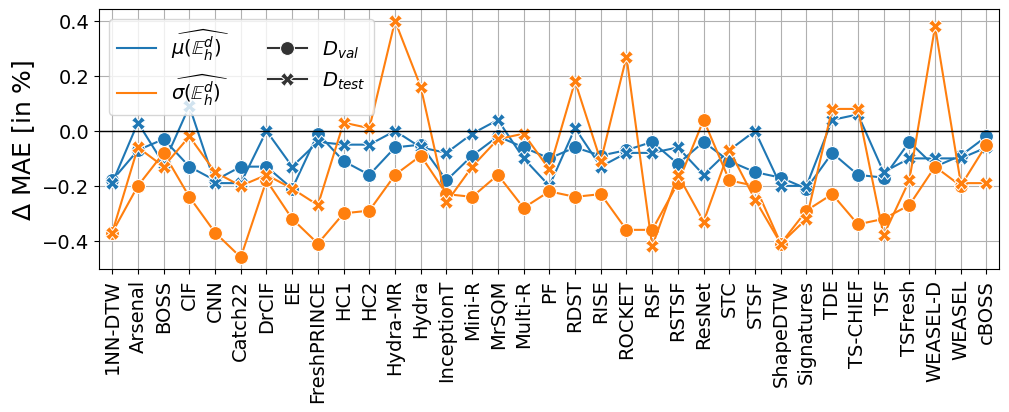

In [8]:
import matplotlib.pyplot as plt
import seaborn as sns

overall_data_frame_mae_sorted = overall_data_frame_mae.sort_values(by=[ "Algorithm"])
df_melted_mae = overall_data_frame_mae_sorted.melt(id_vars=["Algorithm", "predict"], var_name="Subset data", value_name="Performance")

# Prepare algorithm names for x-tick labels, stripping "_ACC"
algorithm_names = [
    algorithm_name.replace("_ACC", "") if "_ACC" in algorithm_name else algorithm_name 
    for algorithm_name in overall_data_frame_mae_sorted['Algorithm'].unique()
]

# Replace values for readability
replace_dict = {"mean": "$\widehat{\mu(\mathbb{E}_{h}^{d})}$", "std": "$\widehat{\sigma(\mathbb{E}_{h}^{d})}$"}
df_melted_mae["predict"] = df_melted_mae["predict"].map(replace_dict)

subset_replace_dict = {"Validation": "$D_{val}$", "Test": "$D_{test}$"}
df_melted_mae["Subset data"] = df_melted_mae["Subset data"].map(subset_replace_dict)

# Create the plots
fig, ax = plt.subplots(1, 1, figsize=(10, 4), sharex=True, sharey=True)

# Line plot for MAE
sns.lineplot(data=df_melted_mae, x="Algorithm", y="Performance", hue="predict", style="Subset data", markers=True, markersize=10, dashes=False, ax=ax)
ax.set_ylabel("$\Delta$ MAE [in $\%$]", fontsize=18)
ax.set_xlim(-0.5, len(df_melted_mae['Algorithm'].unique()) - 0.5)
ax.set_xlabel("", fontsize=18)
ax.tick_params(axis="x", labelsize=14) 
ax.tick_params(axis="y", labelsize=14) 
# Custom legend for MAE
handles, labels = ax.get_legend_handles_labels()
new_labels = [label for label in labels if label in replace_dict.values() or label in subset_replace_dict.values()]
new_handles = [handles[labels.index(label)] for label in new_labels]
ax.legend(new_handles, new_labels, loc='upper left', ncol=2, fontsize=14)
ax.hlines(0, -0.5, len(df_melted_mae['Algorithm'].unique()) - 0.5, color="black", linestyle="-", linewidth=1)
ax.grid(True)

ax.set_xticklabels(algorithm_names, rotation=90, ha="center")

plt.subplots_adjust(hspace=.05, wspace=0.05, left=0.1, right=1., bottom=0.35, top=1.)
fig_saver.save_fig(f"change_performance_only_mae")
plt.show()


/var/folders/ct/qpfxjbdn1xx4fvb2v099sg_00000gn/T/ipykernel_6981/449532438.py:54: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax[1].set_xticklabels(algorithm_names, rotation=90, ha="center")


Saving figure change_performance


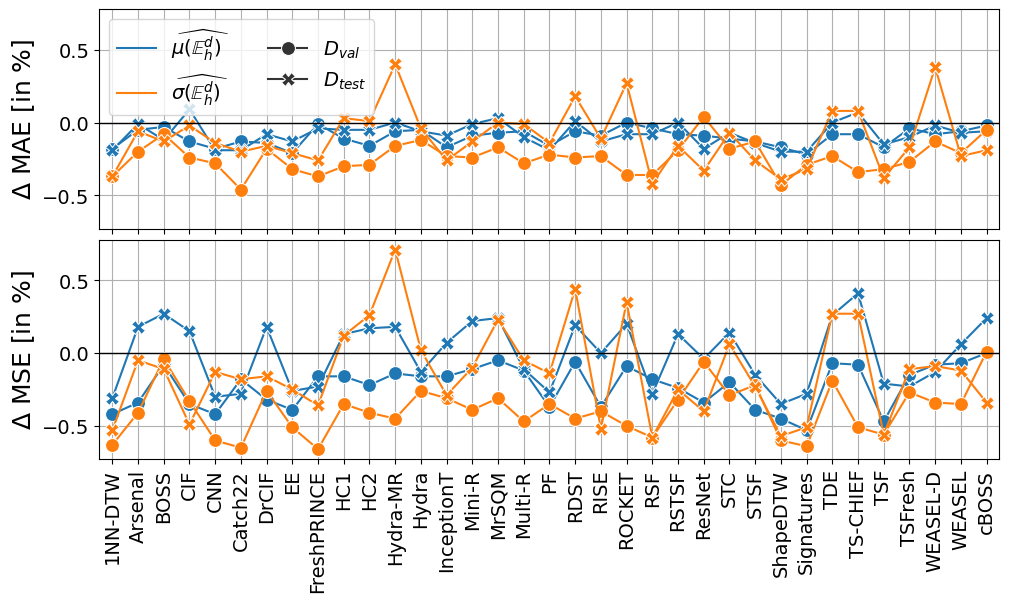

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

# Assuming overall_data_frame_mae and overall_data_frame_mse are predefined DataFrames

# overall_data_frame_mae_sorted = overall_data_frame_mae.sort_values(by=[ "predict", "Validation"])
overall_data_frame_mae_sorted = overall_data_frame_mae.sort_values(by=[ "Algorithm"])
overall_data_frame_mse_sorted = overall_data_frame_mse

df_melted_mae = overall_data_frame_mae_sorted.melt(id_vars=["Algorithm", "predict"], var_name="Subset data", value_name="Performance")
df_melted_mse = overall_data_frame_mse_sorted.melt(id_vars=["Algorithm", "predict"], var_name="Subset data", value_name="Performance")

# Prepare algorithm names for x-tick labels, stripping "_ACC"
algorithm_names = [
    algorithm_name.replace("_ACC", "") if "_ACC" in algorithm_name else algorithm_name 
    for algorithm_name in overall_data_frame_mae_sorted['Algorithm'].unique()
]


# Replace values for readability
replace_dict = {"mean": "$\widehat{\mu(\mathbb{E}_{h}^{d})}$", "std": "$\widehat{\sigma(\mathbb{E}_{h}^{d})}$"}
df_melted_mae["predict"] = df_melted_mae["predict"].map(replace_dict)
df_melted_mse["predict"] = df_melted_mse["predict"].map(replace_dict)

subset_replace_dict = {"Validation": "$D_{val}$", "Test": "$D_{test}$"}
df_melted_mae["Subset data"] = df_melted_mae["Subset data"].map(subset_replace_dict)
df_melted_mse["Subset data"] = df_melted_mse["Subset data"].map(subset_replace_dict)

# Create the plots
fig, ax = plt.subplots(2, 1, figsize=(10, 6), sharex=True, sharey=True)

# Line plot for MAE
sns.lineplot(data=df_melted_mae, x="Algorithm", y="Performance", hue="predict", style="Subset data", markers=True, markersize=10, dashes=False, ax=ax[0])
ax[0].set_ylabel("$\Delta$ MAE [in $\%$]", fontsize=18)
ax[0].set_xlim(-0.5, len(df_melted_mae['Algorithm'].unique()) - 0.5)
ax[0].set_xlabel("", fontsize=18)
ax[0].tick_params(axis="x", labelsize=14) 
ax[0].tick_params(axis="y", labelsize=14) 
# Custom legend for MAE
handles, labels = ax[0].get_legend_handles_labels()
new_labels = [label for label in labels if label in replace_dict.values() or label in subset_replace_dict.values()]
new_handles = [handles[labels.index(label)] for label in new_labels]
ax[0].legend(new_handles, new_labels, loc='upper left', ncol=2, fontsize=14)
ax[0].hlines(0, -0.5, len(df_melted_mae['Algorithm'].unique()) - 0.5, color="black", linestyle="-", linewidth=1)
ax[0].grid(True)

# Line plot for MSE
sns.lineplot(data=df_melted_mse, x="Algorithm", y="Performance", hue="predict", style="Subset data", markers=True, markersize=10, dashes=False, ax=ax[1])
ax[1].set_ylabel("$\Delta$ MSE [in $\%$]", fontsize=18)

ax[1].set_xlabel("", fontsize=18)
ax[1].tick_params(axis="y", labelsize=14) 
ax[1].tick_params(axis="x", labelsize=14, rotation=90) 
ax[1].set_xticklabels(algorithm_names, rotation=90, ha="center")
ax[1].hlines(0, -0.5, len(df_melted_mae['Algorithm'].unique()) - 0.5, color="black", linestyle="-", linewidth=1)

# Hide legend for MSE
ax[1].legend([], [], frameon=False)
ax[1].grid(True)

plt.subplots_adjust(hspace=.05, wspace=0.05, left=0.1, right=1., bottom=0.25, top=1.)
fig_saver.save_fig(f"change_performance")
plt.show()


In [ ]:
import matplotlib.pyplot as plt
import numpy as np
from matplotlib.patches import Polygon


def _visualise_single_algorithm(applied_algorithm = "1NN-DTW_ACC", model_name = "RandomForest",to_predict = 'mean', save_figure = False):

    fig_size = (10, 8)
    fig, ax = plt.subplots(2, 1, figsize=fig_size, sharex=False, sharey=False)
    

    for y_ax, data_sub_set in enumerate(['Validation', 'Test']):

        gt_performance = results_dict[applied_algorithm][to_predict][model_name][data_sub_set]['raw_predictions']["GT Performance"].values
        estimated_performance = results_dict[applied_algorithm][to_predict][model_name][data_sub_set]['raw_predictions'][
            "Estimated Performance"
        ]
        naive_baseline = results_dict[applied_algorithm][to_predict][model_name][data_sub_set]['raw_predictions']["Naive Baseline"][0]

        ax[y_ax].scatter(
            gt_performance,
            estimated_performance,
            label=r'Estimations $\widehat{\mu(\mathbb{E}_{h}^{d})}$' if to_predict == 'mean' else r'Estimations $\widehat{\sigma(\mathbb{E}_{h}^{d})}$',
            marker='o',
            s=100,
            alpha=0.7,
        )
        ax[y_ax].plot(
            [
                results_dict[applied_algorithm][to_predict][model_name][data_sub_set]['raw_predictions']["GT Performance"].values.min()*0.95,
                results_dict[applied_algorithm][to_predict][model_name][data_sub_set]['raw_predictions']["GT Performance"].values.max(),
            ],
            [
                results_dict[applied_algorithm][to_predict][model_name][data_sub_set]['raw_predictions']["Naive Baseline"].max(),
                results_dict[applied_algorithm][to_predict][model_name][data_sub_set]['raw_predictions']["Naive Baseline"].min(),
            ],
            color='tab:orange', linewidth=3, linestyle='--', 
            label= r'Naive Baseline $\ddot{\mu}_{h}^d$' if to_predict == 'mean' else r'Naive Baseline $\ddot{\sigma}_{h}^d$'
            
        )
        # Plot the perfect prediction line
        ax[y_ax].plot([0., 1], [0., 1], color='black', linewidth=3, linestyle='--', label=r'Perfect Prediction ${\mu(\mathbb{E}_{h}^{d})}$' if to_predict == 'mean' else r'Perfect Prediction ${\sigma(\mathbb{E}_{h}^{d})}$')
        
        ax[y_ax].add_patch(Polygon([(naive_baseline,naive_baseline), (0,naive_baseline), (0,-naive_baseline)], facecolor='none', edgecolor='green', hatch='//', label='Better than Naive'))
        ax[y_ax].add_patch(Polygon([(naive_baseline,naive_baseline), (1,naive_baseline), (1,2-naive_baseline)], facecolor='none', edgecolor='green', hatch='//', label=''))

                
        
        
        ax[y_ax].set_xlim(min(gt_performance.min(), estimated_performance.min())*0.95, max(gt_performance.max(), estimated_performance.max()))
        ax[y_ax].set_ylim(min(gt_performance.min(), estimated_performance.min())*0.95, max(gt_performance.max(), estimated_performance.max()))

        if y_ax == 0:
            ax[y_ax].set_ylabel(r'Estimations $\widehat{\mu(\mathbb{E}_{h}^{d})}$' if to_predict == 'mean' else r'Estimations $\widehat{\sigma(\mathbb{E}_{h}^{d})}$', fontsize=18)
            ax[y_ax].legend(loc='lower left' if to_predict == 'mean' else "upper left", ncol=2, fontsize=14)
            ax[y_ax].set_title(r"$d \in D_{val}$", fontsize=18)
            
        else:
            ax[y_ax].set_xlabel(r'Ground truth ${\mu(\mathbb{E}_{h}^{d})}$' if to_predict == 'mean' else r'Ground truth ${\sigma(\mathbb{E}_{h}^{d})}$' , fontsize=18)
            ax[y_ax].set_title(r"$d \in D_{test}$", fontsize=18)
        
        ax[y_ax].tick_params(axis="x",labelsize=18)
        ax[y_ax].tick_params(axis="y", labelsize=18)
        
        
    plt.subplots_adjust(hspace=.25, wspace=0., left=0.11, right=0.95, bottom=0.1, top=.95)
    
    if save_figure:
        fig_saver.save_fig(f"performance_comparison_{applied_algorithm}_{model_name}_{to_predict}")
    plt.show()
    

Saving figure performance_comparison_1NN-DTW_ACC_Ridge_mean


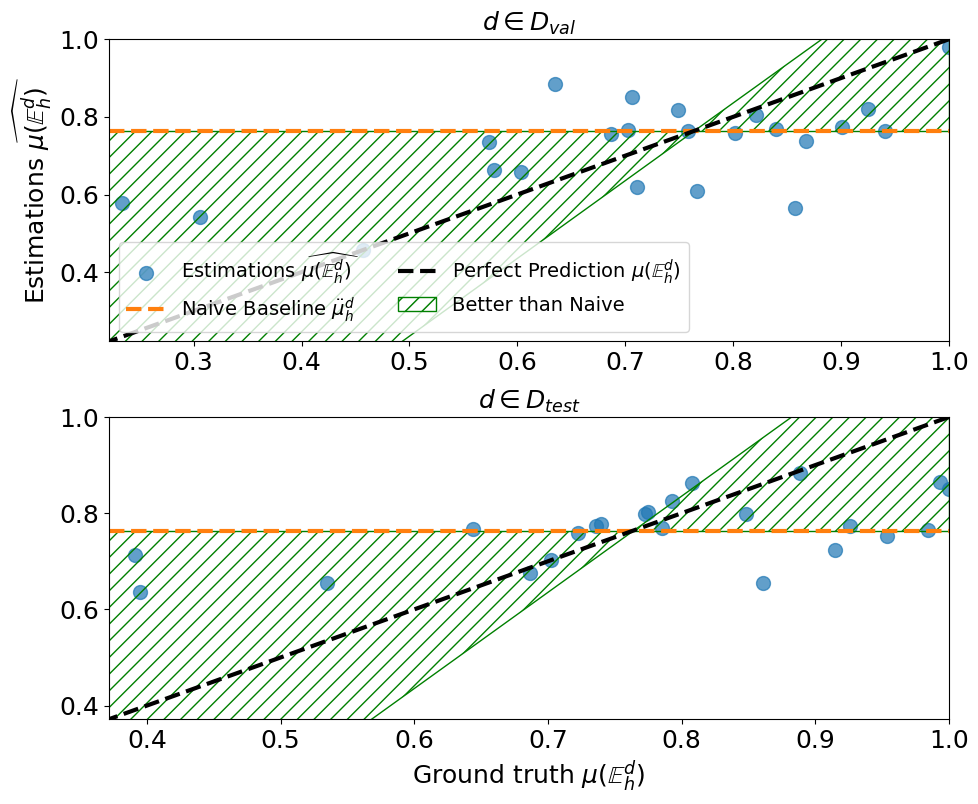

In [ ]:
_visualise_single_algorithm(applied_algorithm = "1NN-DTW_ACC", model_name = "Ridge",to_predict = 'mean', save_figure = True)

Saving figure performance_comparison_1NN-DTW_ACC_RandomForest_std


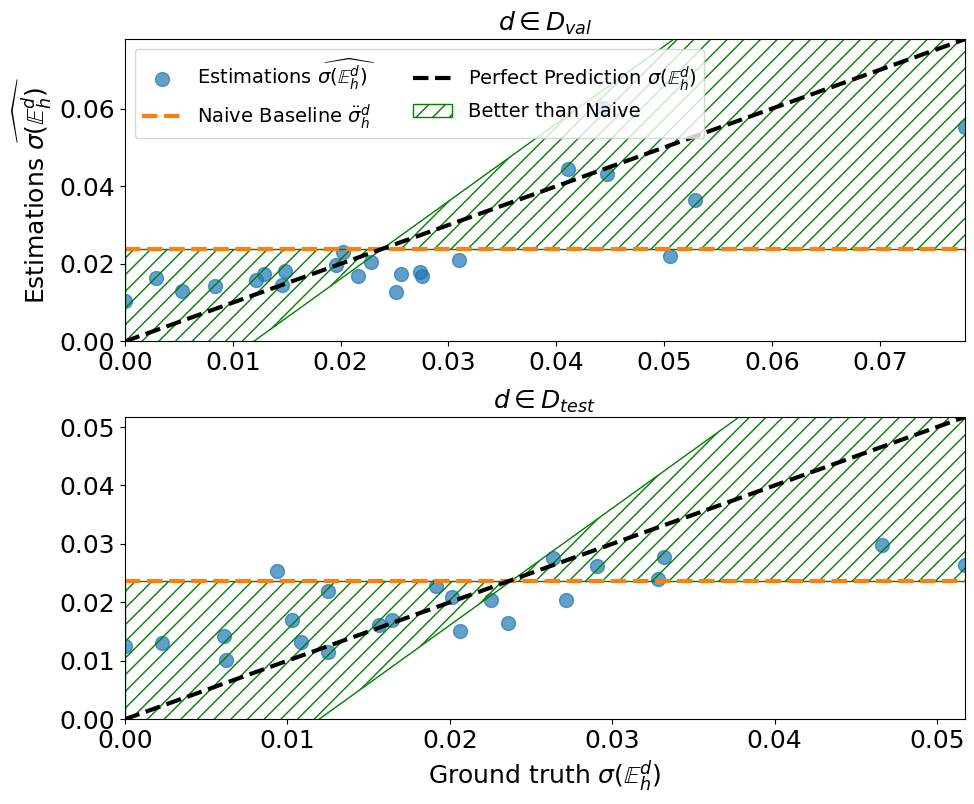

In [ ]:
_visualise_single_algorithm(applied_algorithm = "1NN-DTW_ACC", model_name = "RandomForest",to_predict = 'std', save_figure = True)

# Markdown table

I have a dictionary holding all my experiment results called results_dict, an example looks like this: 
results_dict['ResNet_ACC']['mean']['Ridge']['Test']['metrics'] = {'Naive MAE': 0.12141836789546905,
 'Naive MSE': 0.02367611469498394,
 'Model MAE': 0.09444778888604165,
 'Model MSE': 0.01891334753048512,
 'Improvement MAE': -0.22212931599152105,
 'Improvement MSE': -0.20116337607993873}

I want to convert it into a pandas data frame with perhaps multi index and multi column - not sure, depends. I will first describe the dictionary and then the desired data frame. Please then write me a function that I can adapt easily afterwards. 
Structre: 
- first level keys: are the names of the different experiments 
- second level keys: are the names of the different metrics
- third level keys: are the names of the different models used for prediction 
- fourth level keys: are the names of the different data sets used evaluated on, namely validation and test
- fifth level keys: are the names of the different evaluation metrics, such as Naive baseline, MAE, etc.

In [ ]:
# Initialize a list to store the multi-index and columns data
records = []

# Iterate over the nested dictionary structure
for experiment, metrics_dict in results_dict.items():
    for metric, models_dict in metrics_dict.items():
        for model, datasets_dict in models_dict.items():
            for dataset, metrics_data in datasets_dict.items():
                for evaluation_metric, value in metrics_data['metrics'].items():
                    records.append({
                        'Algorithm': experiment,
                        'estimate': metric,
                        'Model': model,
                        'Dataset': dataset,
                        'Metric': evaluation_metric,
                        'Value': value
                    })

# Convert the list of dictionaries into a DataFrame
df = pd.DataFrame(records)

# Pivot the DataFrame to get a multi-level column structure
df_pivoted = df.pivot_table(index=['Algorithm', 'estimate'],
                            columns=['Model', 'Dataset', 'Metric'],
                            values='Value').reset_index()

# Function to combine metrics into a single string for each 'MAE' and 'MSE'
def combine_metrics(row, metrics):
    combined_metrics = {}
    for metric in metrics:
        naive = row[f"Naive {metric}"]
        model = row[f"Model {metric}"]
        improvement = (model - naive) / naive * 100  
        # combined_metrics[metric] = f"{naive:.4f} / {model:.4f} ({improvement:.2f})"
        combined_metrics[metric] = f"{improvement:.2f}"
    return pd.Series(combined_metrics)

# Iterate over unique 'Model' and 'Dataset' pairs to apply the combine_metrics function
for (model, dataset), group_df in df.groupby(['Model', 'Dataset']):
    metrics = ['MAE', 'MSE']
    combined = df_pivoted.apply(lambda row: combine_metrics(row[(model, dataset)], metrics), axis=1)
    for metric in metrics:
        df_pivoted[(model, dataset, metric)] = combined[metric]

df_pivoted.set_index(['Algorithm', 'estimate'], inplace=True)

idx = pd.IndexSlice
filtered_df_MAE = df_pivoted.loc[:, idx[:, :, ['MAE']]]
filtered_df_MSE = df_pivoted.loc[:, idx[:, :, ['MSE']]]

In [ ]:
filtered_df_MAE = filtered_df_MAE.reset_index(drop=False)
filtered_df_MAE[(       'Algorithm',           '',    '')] = filtered_df_MAE[(       'Algorithm',           '',    '')].apply(
    lambda x: x.replace("_ACC", "") if x.endswith("_ACC") else x
)
print(filtered_df_MAE.to_latex(index=True))


# filtered_df_MSE = filtered_df_MSE.reset_index(drop=False)
# filtered_df_MSE[(       'Algorithm',           '',    '')] = filtered_df_MSE[(       'Algorithm',           '',    '')].apply(
#     lambda x: x.replace("_ACC", "") if x.endswith("_ACC") else x
# )
# print(filtered_df_MSE.to_latex(index=True))

\begin{tabular}{lllllllllllllllll}
\toprule
Model & Algorithm & estimate & \multicolumn{2}{r}{AdaBoost} & \multicolumn{2}{r}{DecisionTree} & \multicolumn{2}{r}{GradientBoosting} & \multicolumn{2}{r}{KNeighbors} & \multicolumn{2}{r}{RandomForest} & \multicolumn{2}{r}{Ridge} & \multicolumn{2}{r}{SVR} \\
Dataset &  &  & Test & Validation & Test & Validation & Test & Validation & Test & Validation & Test & Validation & Test & Validation & Test & Validation \\
Metric &  &  & MAE & MAE & MAE & MAE & MAE & MAE & MAE & MAE & MAE & MAE & MAE & MAE & MAE & MAE \\
\midrule
0 & 1NN-DTW & mean & 6.02 & -13.13 & 32.00 & 19.50 & 1.63 & -6.42 & -9.41 & 2.16 & -1.23 & -12.91 & -18.61 & -18.13 & -7.36 & -5.95 \\
1 & 1NN-DTW & std & -25.23 & -27.95 & -23.11 & -30.61 & -32.44 & -33.27 & -15.90 & -13.70 & -37.32 & -37.49 & -8.37 & -6.32 & 119.22 & 55.43 \\
2 & Arsenal & mean & 2.60 & -6.62 & -22.91 & 16.38 & -13.38 & 27.71 & -7.52 & -0.09 & -0.71 & -4.63 & -19.51 & 5.71 & -6.42 & 7.58 \\
3 & Arsenal & std 

# Main paper table

In [ ]:
# Initialize a list to hold extracted data for DataFrame
data = []

# Determine the best model for each task based on validation set performance
best_model_dict = _get_best_model_for_each_task(results_dict, metric_to_use_for_selection)

# Iterate over the results to populate the data list
for algorithm, metrics in results_dict.items():
    for metric_type in metrics:  # 'mean' or 'std'
        best_model, _ = best_model_dict[algorithm][metric_type]
        metrics_data = results_dict[algorithm][metric_type][best_model]['Test']['metrics']
        
        # Create a record for each metric
        record = {
            'Algorithm': algorithm,
            'Metric Type': metric_type,
            'Model': best_model,
        }|metrics_data
        
        data.append(record)

# Convert the list of data to a DataFrame
df = pd.DataFrame(data)

# Pivot the DataFrame to structure 'Metric Type' as part of the column multi-level
df_pivoted = df.pivot_table(index=['Algorithm'],
                            columns=['Metric Type'],
                            aggfunc=lambda x: x)

# After pivoting, 'Metric Type' will become the top level of the columns, organizing 'mean' and 'std' accordingly
# The aggfunc=lambda x: x is a placeholder to simply return the original values
df_pivoted.sort_index(axis=1, level=1, inplace=True)

table_paper = df_pivoted.T.sort_values(by=("Metric Type")).T[[
            (          'Model', 'mean'),
            (      'Naive MAE', 'mean'),
            (      'Model MAE', 'mean'),
            ('Improvement MAE', 'mean'),
            (      'Naive MSE', 'mean'),
            (      'Model MSE', 'mean'),
            ('Improvement MSE', 'mean'),
            (          'Model',  'std'),
            (      'Naive MAE',  'std'),
            (      'Model MAE',  'std'),
            ('Improvement MAE',  'std'),
            (      'Naive MSE',  'std'),
            (      'Model MSE',  'std'),
            ('Improvement MSE',  'std'),
            ]]

Best model for ResNet_ACC and mean is AdaBoost with improvement -0.09433881062721454
Best model for ResNet_ACC and std is KNeighbors with improvement 0.04280934132222486
Best model for 1NN-DTW_ACC and mean is Ridge with improvement -0.18134421644564452
Best model for 1NN-DTW_ACC and std is RandomForest with improvement -0.3749183191220172
Best model for EE_ACC and mean is Ridge with improvement -0.21443491490559893
Best model for EE_ACC and std is DecisionTree with improvement -0.31847680668009265
Best model for WEASEL-D_ACC and mean is RandomForest with improvement -0.07510129899661554
Best model for WEASEL-D_ACC and std is DecisionTree with improvement -0.1344978290428769
Best model for RSF_ACC and mean is KNeighbors with improvement -0.035547479347857486
Best model for RSF_ACC and std is RandomForest with improvement -0.3597502792869466
Best model for CNN_ACC and mean is Ridge with improvement -0.18026993812017622
Best model for CNN_ACC and std is RandomForest with improvement -0.28

In [ ]:
# Remove the "_ACC" suffix from the algorithm names
table_paper.index = table_paper.index.str.replace("_ACC", "")

# map the model names to abbreviations of two letters
model_name_mapping = {
    'Ridge': 'Ri',
    'RandomForest': 'RF',
    'DecisionTree': 'DT',
    'GradientBoosting': 'GB',
    'AdaBoost': 'AB',
    "KNeighbors": 'KN',
}
table_paper[[
            (          'Model', 'mean'),
            (          'Model',  'std'),
            ]] = table_paper[[
            (          'Model', 'mean'),
            (          'Model',  'std'),
            ]].applymap(lambda x: model_name_mapping[x])
            
# calculate the means and add it to the table
table_paper= table_paper.convert_dtypes()
table_paper = pd.concat([table_paper, table_paper.mean(numeric_only=True).to_frame().T])
table_paper = table_paper.round(4)

# improve the readability of the table by multiplying the improvement by 100
for column in table_paper.columns:
    if "Improvement" in column[0]:
        table_paper[column] = table_paper[column]*100
        table_paper[column] = table_paper[column].map('{:,.2f}'.format)


/var/folders/ct/qpfxjbdn1xx4fvb2v099sg_00000gn/T/ipykernel_6981/2364798824.py:19: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  ]].applymap(lambda x: model_name_mapping[x])


In [ ]:
table_paper

,Model,Naive MAE,Model MAE,Improvement MAE,Naive MSE,Model MSE,Improvement MSE,Model,Naive MAE,Model MAE,Improvement MAE,Naive MSE,Model MSE,Improvement MSE
Metric Type,mean,mean,mean,mean,mean,mean,mean,std,std,std,std,std,std,std
1NN-DTW,Ri,0.1277,0.1039,-18.61,0.0275,0.0189,-31.45,RF,0.011,0.0069,-37.32,0.0002,0.0001,-53.23
Arsenal,RF,0.1046,0.1039,-0.71,0.0191,0.0225,17.87,RF,0.0094,0.0088,-5.63,0.0001,0.0001,-5.12
BOSS,Ri,0.1242,0.1099,-11.55,0.0235,0.0213,-9.46,Ri,0.0134,0.0117,-12.58,0.0003,0.0002,-11.26
CIF,RF,0.1072,0.1165,8.65,0.0203,0.0234,14.95,DT,0.0125,0.0122,-1.71,0.0002,0.0002,14.13
CNN,Ri,0.1786,0.144,-19.37,0.044,0.0307,-30.19,RF,0.0184,0.0159,-13.53,0.0005,0.0004,-12.88
Catch22,Ri,0.1205,0.098,-18.67,0.0228,0.0164,-28.15,DT,0.0122,0.0098,-19.92,0.0002,0.0002,-18.35
DrCIF,AB,0.1054,0.0973,-7.70,0.017,0.0186,9.33,RF,0.011,0.0093,-15.67,0.0002,0.0001,-16.26
EE,Ri,0.1159,0.1013,-12.64,0.0221,0.0164,-26.08,DT,0.0127,0.01,-20.82,0.0002,0.0002,-25.17
FreshPRINCE,DT,0.1157,0.1111,-3.97,0.0199,0.0254,27.32,GB,0.0122,0.009,-25.98,0.0002,0.0001,-35.66


In [ ]:
print(table_paper.astype(str).to_latex())

\begin{tabular}{lllllllllllllll}
\toprule
 & Model & Naive MAE & Model MAE & Improvement MAE & Naive MSE & Model MSE & Improvement MSE & Model & Naive MAE & Model MAE & Improvement MAE & Naive MSE & Model MSE & Improvement MSE \\
Metric Type & mean & mean & mean & mean & mean & mean & mean & std & std & std & std & std & std & std \\
\midrule
1NN-DTW & Ri & 0.1277 & 0.1039 & -18.61 & 0.0275 & 0.0189 & -31.45 & RF & 0.011 & 0.0069 & -37.32 & 0.0002 & 0.0001 & -53.23 \\
Arsenal & RF & 0.1046 & 0.1039 & -0.71 & 0.0191 & 0.0225 & 17.87 & RF & 0.0094 & 0.0088 & -5.63 & 0.0001 & 0.0001 & -5.12 \\
BOSS & Ri & 0.1242 & 0.1099 & -11.55 & 0.0235 & 0.0213 & -9.46 & Ri & 0.0134 & 0.0117 & -12.58 & 0.0003 & 0.0002 & -11.26 \\
CIF & RF & 0.1072 & 0.1165 & 8.65 & 0.0203 & 0.0234 & 14.95 & DT & 0.0125 & 0.0122 & -1.71 & 0.0002 & 0.0002 & 14.13 \\
CNN & Ri & 0.1786 & 0.144 & -19.37 & 0.044 & 0.0307 & -30.19 & RF & 0.0184 & 0.0159 & -13.53 & 0.0005 & 0.0004 & -12.88 \\
Catch22 & Ri & 0.1205 & 0.098 & -1